In [3]:
import numpy as np
from scipy.stats import multinomial
import matplotlib.pyplot as plt
import pandas as pd

# Theta

The DB_V and DB_H events do not occur independently across the trials.

The 'DB_V', 'DB_H' and 'neither' events occur in the N samples as a multinomial distribution.

## As per paper

In [43]:
# plot the multinomial distribution

n = 40

theta = 0.25 * np.pi

p_dbh = 1 / 4 * (1 + np.cos(theta)) ** 2
p_dbv = 1 / 4 * (1 - np.cos(theta)) ** 2

p_neither = 1 - p_dbh - p_dbv

p = [p_dbh, p_dbv, p_neither]

multinom_db = multinomial(n, p)

multinom_db.pmf([40, 0, 0])

np.float64(3.1510503835036592e-06)

In [44]:
def get_multinom_difference_pmf(n, theta):
    z_range = np.arange(-n, n + 1)
    pmf_z = np.zeros(2 * n + 1)

    p_dbh = 1 / 4 * (1 + np.cos(theta)) ** 2
    p_dbv = 1 / 4 * (1 - np.cos(theta)) ** 2
    p_neither = 1 - p_dbh - p_dbv

    p = [p_dbh, p_dbv, p_neither]

    multinom_db = multinomial(n, p)

    range_i = np.arange(0, n + 1)

    # https://math.stackexchange.com/questions/562119/difference-of-two-binomial-random-variables
    for i, z in enumerate(z_range):
        pmf_z[i] = np.sum([multinom_db.pmf([z + i, i, n - z - 2 * i]) for i in range_i])

    return z_range, pmf_z

In [45]:
def get_multinom_difference_pmf(n, theta):
    p_dbh = 1 / 4 * (1 + np.cos(theta)) ** 2
    p_dbv = 1 / 4 * (1 - np.cos(theta)) ** 2
    p_neither = 1 - p_dbh - p_dbv

    p = [p_dbh, p_dbv, p_neither]
    multinom_db = multinomial(n, p)

    n_counts = [[i, j, n - i - j] for i in range(n + 1) for j in range(n + 1 - i)]

    pmf_counts = multinom_db.pmf(n_counts)

    pmf_cos_theta = pd.DataFrame(n_counts)

    pmf_cos_theta["pmf"] = pmf_counts
    pmf_cos_theta["n_dbh"] = pmf_cos_theta[0].astype(int)
    pmf_cos_theta["n_dbv"] = pmf_cos_theta[1].astype(int)
    pmf_cos_theta["n_neither"] = pmf_cos_theta[2].astype(int)

    pmf_cos_theta["numerator"] = pmf_cos_theta["n_dbh"] - pmf_cos_theta["n_dbv"]
    pmf_cos_theta["denominator"] = (
        pmf_cos_theta["n_dbh"] + pmf_cos_theta["n_dbv"] + pmf_cos_theta["n_neither"]
    )
    pmf_cos_theta["cos_theta"] = (
        pmf_cos_theta["numerator"] / pmf_cos_theta["denominator"]
    )
    pmf_cos_theta["pmf_theta_tilde"] = np.arccos(pmf_cos_theta["cos_theta"])

    # sum up contributions for the same theta_tilde
    pmf_cos_theta = pmf_cos_theta.groupby("pmf_theta_tilde").sum()["pmf"]
    pmf_cos_theta = pmf_cos_theta.reset_index()

    # renormalise to account for rounding errors
    pmf_cos_theta["pmf"] = pmf_cos_theta["pmf"] / np.sum(pmf_cos_theta["pmf"])

    return pmf_cos_theta

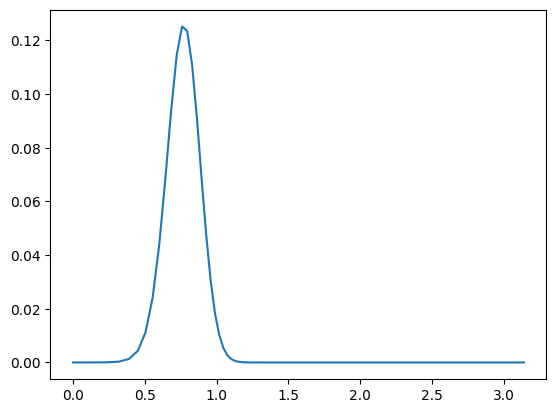

In [46]:
num_samples = 40
pmf_z = get_multinom_difference_pmf(num_samples, 0.25 * np.pi)
plt.plot(pmf_z["pmf_theta_tilde"], pmf_z["pmf"])
plt.show()

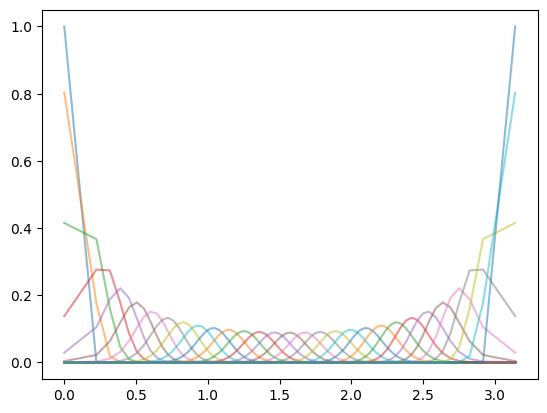

In [47]:
# show some of the pmfs for different thetas
theta_range = np.linspace(0, np.pi, 31)

# get the pmf for each theta
pmfs = [get_multinom_difference_pmf(n, theta) for theta in theta_range]

# plot the pmfs
plt.figure()
for pmf in pmfs:
    plt.plot(pmf["pmf_theta_tilde"], pmf["pmf"], alpha=0.5)

plt.show()

In [48]:
def calculate_multinom_stats(theta_samples, n):
    theta_range = np.linspace(0, np.pi, theta_samples)
    pmfs = [get_multinom_difference_pmf(n, theta) for theta in theta_range]

    variances = []
    means = []

    for pmf in pmfs:
        mean = np.sum(pmf["pmf_theta_tilde"] * pmf["pmf"])
        var = np.sum(pmf["pmf_theta_tilde"] ** 2 * pmf["pmf"]) - mean**2

        means.append(mean)
        variances.append(var)

    return theta_range, means, variances

In [49]:
theta_samples = 501
n = 100
theta_range, means, variances = calculate_multinom_stats(theta_samples, n)

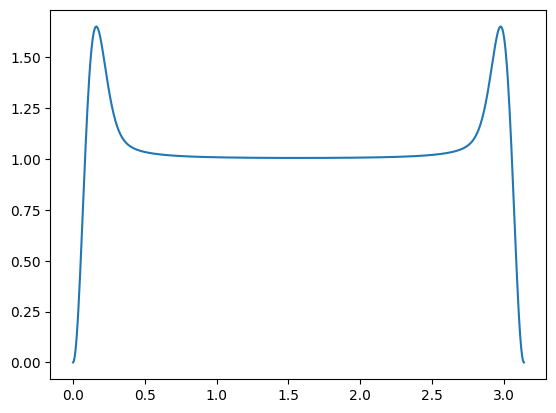

In [50]:
plt.plot(theta_range, np.multiply(2 * n, variances))
plt.show()

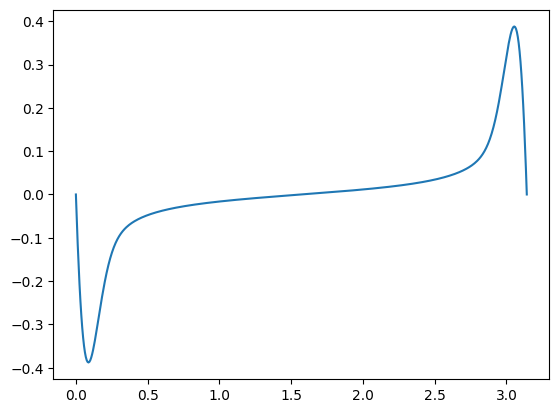

In [51]:
plt.plot(theta_range, np.multiply(np.sqrt(n), means - theta_range))
plt.show()

In [52]:
theta_samples = 501
n_range = [40, 80, 120, 160, 200]
theta_range = np.linspace(0, np.pi, theta_samples)

In [53]:
# get the means and variances for each n
means = []
variances = []

for n in n_range:
    _, m, v = calculate_multinom_stats(theta_samples, n)
    means.append(m)
    variances.append(v)

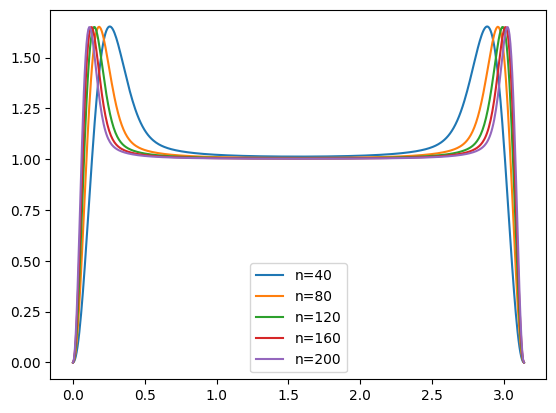

In [54]:
plt.figure()
for n in n_range:
    plt.plot(
        theta_range, np.multiply(2 * n, variances[n_range.index(n)]), label=f"n={n}"
    )

plt.legend()
plt.show()

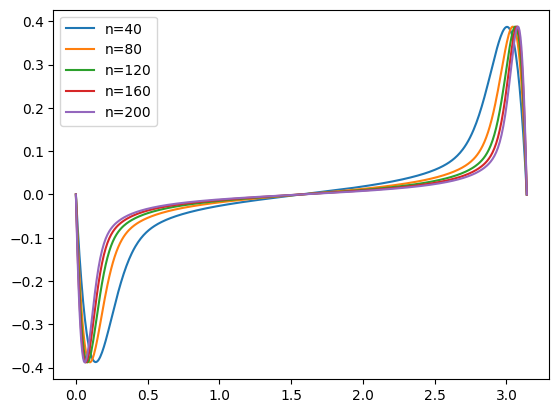

In [55]:
plt.figure()
for n in n_range:
    plt.plot(
        theta_range,
        np.multiply(np.sqrt(n), means[n_range.index(n)] - theta_range),
        label=f"n={n}",
    )

plt.legend()
plt.show()

In [56]:
df = pd.DataFrame({
    "theta": np.tile(theta_range, len(n_range)),
    "n": np.repeat(n_range, len(theta_range)),
    "theta_estimator_mean": np.concatenate(means),
    "theta_estimator_variance": np.concatenate(variances)
})

df.to_csv("theta_estimator_stats.csv", index=False)
df

,theta,n,theta_estimator_mean,theta_estimator_variance
0,0.000000,40,0.000000,0.000000
1,0.006283,40,0.000177,0.000040
2,0.012566,40,0.000707,0.000158
3,0.018850,40,0.001589,0.000354
4,0.025133,40,0.002820,0.000626
...,...,...,...,...
2500,3.116460,200,3.135388,0.000594
2501,3.122743,200,3.138075,0.000343
2502,3.129026,200,3.140020,0.000156
2503,3.135309,200,3.141198,0.000039


## Adding PPNRD

### Estimating N

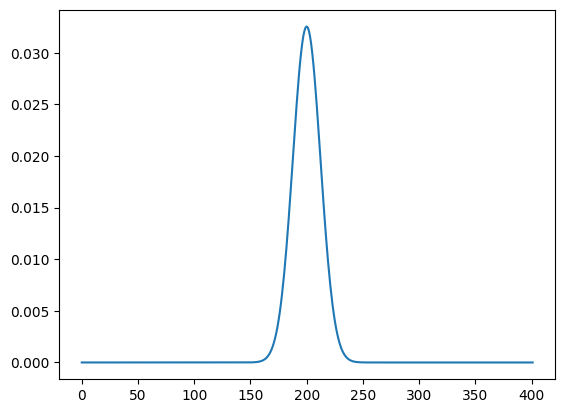

In [57]:
# n_tilde = n_dc + n_ppnrd
# n_dc: double click events
# n_ppnrd: ppnrd-resolved events
n = 200

theta = np.pi / 4
p_dc = 1 / 2 * (np.sin(theta)) ** 2
p_ppnrd = 1 / 4 * (1 + np.cos(theta) ** 2)

p_neither = 1 - p_dc - p_ppnrd

p = [p_dc, p_ppnrd, p_neither]
multinom_n_tilde = multinomial(n, p)

# calculate the pmf for n_tilde
pmf = np.zeros(2 * (n + 1))

for n_tilde in range(
    2 * (n + 1)
):  # can over estimate n if all events are double clicks
    pmf[n_tilde] = np.sum(
        [
            multinom_n_tilde.pmf(
                [n_dc, (n_tilde - n_dc) / 2, n - n_dc - (n_tilde - n_dc) / 2]
            )
            for n_dc in range(n + 1)
        ]
    )

# plot
plt.plot(range(2 * (n + 1)), pmf)
plt.show()

This will be necessary when it comes to saying how close we are to saturating the bound, since we will need to estimate the value of N to know what the bound is.

### Re-estimating theta with Ñ

With $\tilde{\theta} = \arccos (\frac{2(N_{DB_{H}}'+N_{DB_{V}}')}{\tilde{N}})$ where $\tilde{N} = 2(N_{DB_{H}}' + N_{DB_{V}}') + N_{dc}$ 

In [58]:
n = 40

theta = 0.25 * np.pi
delta = 0.25 * np.pi

p_hr = 1 / 8 * (1 + np.cos(theta)) ** 2
p_vr = 1 / 8 * (1 - np.cos(theta)) ** 2
p_dc = 1 / 2 * (np.sin(theta)) ** 2
p_other = 1 - p_hr - p_vr - p_dc  # lost event

p = [p_hr, p_vr, p_dc, p_other]

multinom_db = multinomial(n, p)

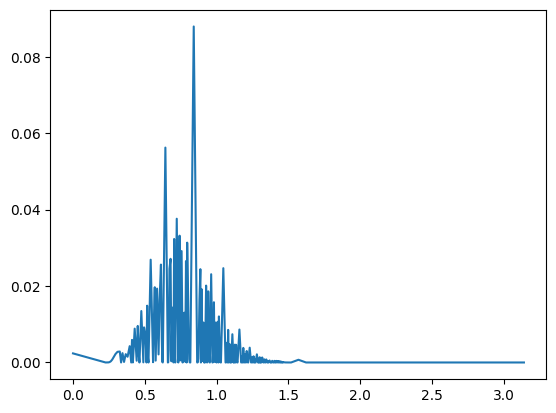

In [59]:
def get_multinom_ppnrd_ratio_pmf(n, theta):
    p_hr = 1 / 8 * (1 + np.cos(theta)) ** 2
    p_vr = 1 / 8 * (1 - np.cos(theta)) ** 2
    p_dc = 1 / 2 * (np.sin(theta)) ** 2
    p_other = 1 - p_hr - p_vr - p_dc

    p = [p_hr, p_vr, p_dc, p_other]

    multinom_ppnrd = multinomial(n, p)

    n_counts = [
        [k, l, m, n - k - l - m]
        for k in range(n + 1)
        for l in range(n + 1 - k)
        for m in range(n + 1 - k - l)
    ]

    # calculate the pmf
    pmf_counts = multinom_ppnrd.pmf(n_counts)

    # arrange in pd data frame with counts as columns
    pmf_cos_theta = pd.DataFrame(n_counts)
    pmf_cos_theta["pmf"] = pmf_counts
    pmf_cos_theta["n_hr"] = pmf_cos_theta[0].astype(int)
    pmf_cos_theta["n_vr"] = pmf_cos_theta[1].astype(int)
    pmf_cos_theta["n_dc"] = pmf_cos_theta[2].astype(int)
    pmf_cos_theta["n_other"] = pmf_cos_theta[3].astype(int)

    pmf_cos_theta["numerator"] = 2 * (pmf_cos_theta["n_hr"] - pmf_cos_theta["n_vr"])
    pmf_cos_theta["denominator"] = (
        2 * (pmf_cos_theta["n_hr"] + pmf_cos_theta["n_vr"]) + pmf_cos_theta["n_dc"]
    )
    pmf_cos_theta["cos_theta"] = (
        pmf_cos_theta["numerator"] / pmf_cos_theta["denominator"]
    )
    pmf_cos_theta["pmf_theta_tilde"] = np.arccos(pmf_cos_theta["cos_theta"])

    # sum up contributions for the same theta_tilde
    pmf_cos_theta = pmf_cos_theta.groupby("pmf_theta_tilde").sum()["pmf"]
    pmf_cos_theta = pmf_cos_theta.reset_index()

    # renormalise to account for rounding errors
    pmf_cos_theta["pmf"] = pmf_cos_theta["pmf"] / np.sum(pmf_cos_theta["pmf"])

    return pmf_cos_theta


num_samples = 20
pmf_s = get_multinom_ppnrd_ratio_pmf(num_samples, 0.25 * np.pi)
plt.plot(pmf_s["pmf_theta_tilde"], pmf_s["pmf"])
plt.show()

In [60]:
# should be 1
# could be less because of values outside the range [-1, 1] which do not give a valid theta
sum(pmf_s["pmf"])

1.0

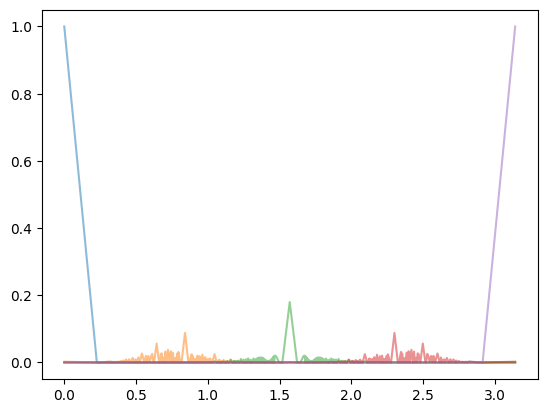

In [61]:
# show some of the pmfs for different thetas
theta_range = np.linspace(0, np.pi, 5)

# get the pmf for each theta
n = 20
pmf_z = [get_multinom_ppnrd_ratio_pmf(n, theta) for theta in theta_range]

# plot the pmfs
plt.figure()
for pmf in pmf_z:
    plt.plot(pmf["pmf_theta_tilde"], pmf["pmf"], alpha=0.5)

plt.show()

In [62]:
def calculate_multinom_ppnrd_stats(theta_samples, n):
    theta_range = np.linspace(0, np.pi, theta_samples)
    pmf_z = [get_multinom_ppnrd_ratio_pmf(n, theta) for theta in theta_range]

    variances = []
    means = []

    for pmf in pmf_z:
        theta_tilde = pmf["pmf_theta_tilde"]
        pmf = pmf["pmf"]

        mean = np.sum(theta_tilde * pmf)
        var = np.sum((theta_tilde) ** 2 * pmf) - mean**2

        means.append(mean)
        variances.append(var)

    return theta_range, means, variances

In [63]:
theta_samples = 11
n = 20
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

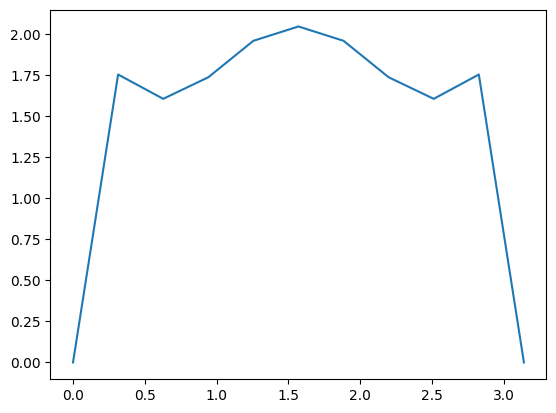

In [64]:
plt.plot(theta_range, np.multiply(2 * n, variances))
plt.show()

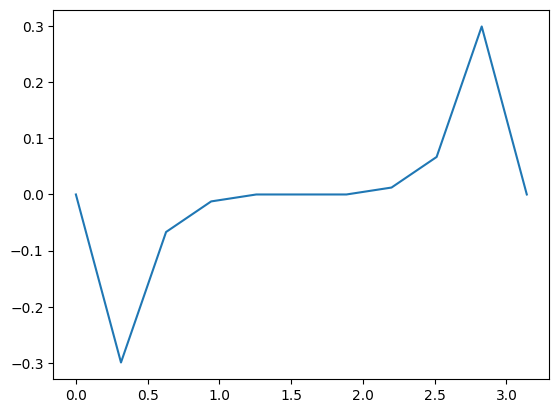

In [65]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

In [66]:
theta_samples = 11
n = 40
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

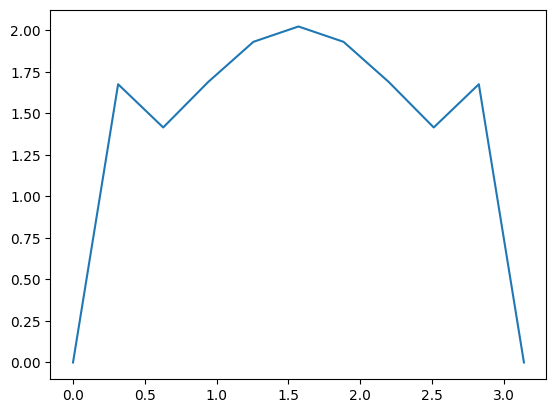

In [67]:
plt.plot(theta_range, np.multiply(2 * n, variances))
plt.show()

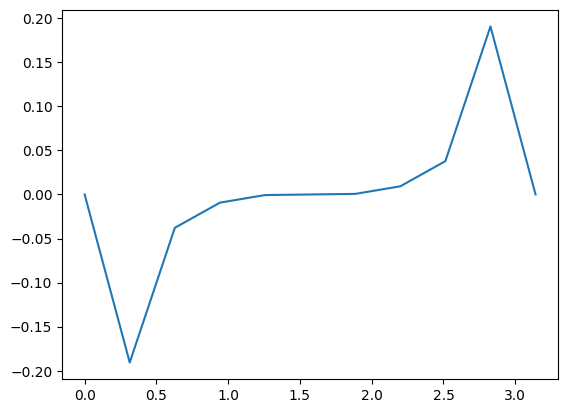

In [68]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

In [69]:
theta_samples = 101
n = 80
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

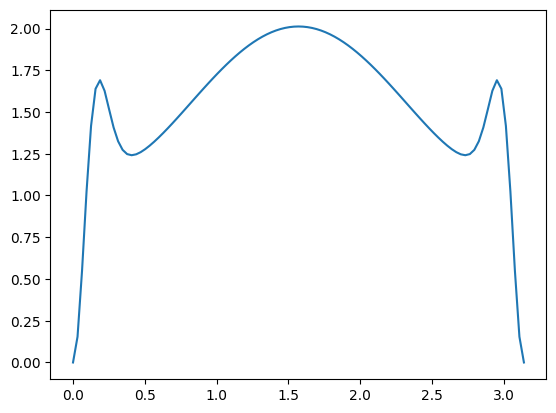

In [70]:
plt.plot(theta_range, np.multiply(2 * n, variances))
plt.show()

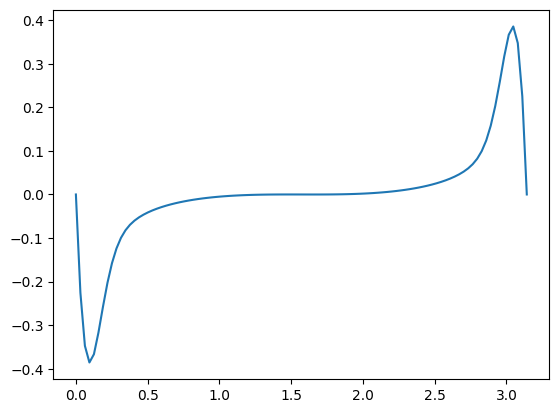

In [71]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

### Ammended distributions excluding lost events

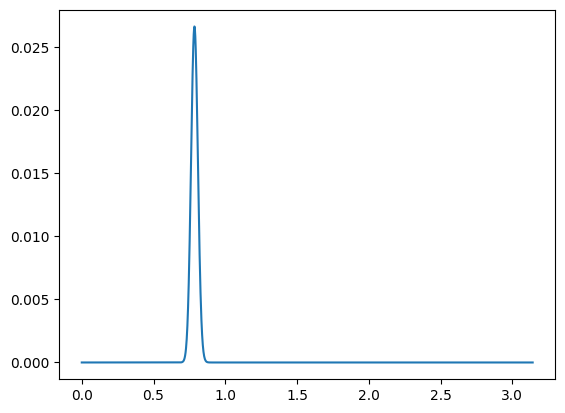

In [72]:
def get_multinom_ppnrd_ratio_pmf(n, theta):
    p_hr = 2 * (np.cos(theta / 2) ** 4) / (3 - np.cos(theta) ** 2)
    p_vr = 2 * (np.sin(theta / 2) ** 4) / (3 - np.cos(theta) ** 2)
    p_dc = 2 * (np.sin(theta)) ** 2 / (3 - np.cos(theta) ** 2)

    p = [p_hr, p_vr, p_dc]

    multinom_ppnrd = multinomial(n, p)

    # arrange all quadruples of counts 0, 1, 2, ..., n in pd data frame
    # n_counts = pd.DataFrame([{"n_hr": k ,"n_vr": l, "n_dc": m, "n_lost": n-k-l-m} for k in range(n+1) for l in range(n+1) for m in range(n+1)])
    n_counts = [[k, l, n - k - l] for k in range(n + 1) for l in range(n + 1 - k)]

    # calculate the pmf
    pmf_counts = multinom_ppnrd.pmf(n_counts)

    # arrange in pd data frame with counts as columns
    pmf_cos_theta = pd.DataFrame(n_counts)
    pmf_cos_theta["pmf"] = pmf_counts
    pmf_cos_theta["n_hr"] = pmf_cos_theta[0].astype(int)
    pmf_cos_theta["n_vr"] = pmf_cos_theta[1].astype(int)
    pmf_cos_theta["n_dc"] = pmf_cos_theta[2].astype(int)

    pmf_cos_theta["under_the_sqrt"] = (
        n**2 + 3 * (pmf_cos_theta["n_hr"] - pmf_cos_theta["n_vr"]) ** 2
    )
    pmf_cos_theta["numerator"] = -n + np.sqrt(pmf_cos_theta["under_the_sqrt"])
    pmf_cos_theta["denominator"] = pmf_cos_theta["n_hr"] - pmf_cos_theta["n_vr"]

    pmf_cos_theta["cos_theta"] = (
        pmf_cos_theta["numerator"] / pmf_cos_theta["denominator"]
    )

    pmf_cos_theta["pmf_theta_tilde"] = np.arccos(pmf_cos_theta["cos_theta"])

    # sum up contributions for the same theta_tilde
    pmf_cos_theta = pmf_cos_theta.groupby("pmf_theta_tilde").sum()["pmf"]
    pmf_cos_theta = pmf_cos_theta.reset_index()

    # renormalise to account for rounding errors
    pmf_cos_theta["pmf"] = pmf_cos_theta["pmf"] / np.sum(pmf_cos_theta["pmf"])

    return pmf_cos_theta


num_samples = 800
pmf_s = get_multinom_ppnrd_ratio_pmf(num_samples, 0.25 * np.pi)
plt.plot(pmf_s["pmf_theta_tilde"], pmf_s["pmf"])
plt.show()

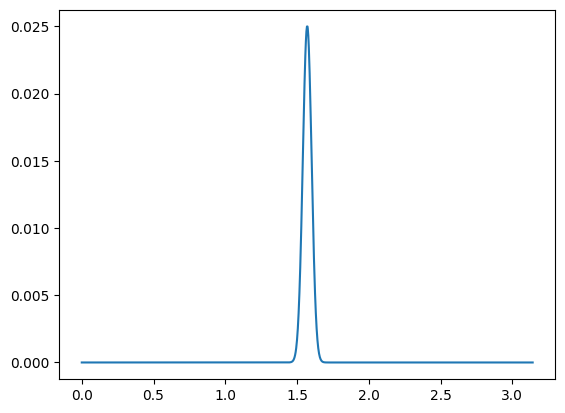

In [73]:
num_samples = 800
pmf_s = get_multinom_ppnrd_ratio_pmf(num_samples, np.pi / 2)
plt.plot(pmf_s["pmf_theta_tilde"], pmf_s["pmf"])
plt.show()

In [74]:
# sum of the pmf should be 1
sum(pmf_s["pmf"])

1.0

In [75]:
def calculate_multinom_ppnrd_stats(theta_samples, n):
    theta_range = np.linspace(0, np.pi, theta_samples)
    pmf_z = [get_multinom_ppnrd_ratio_pmf(n, theta) for theta in theta_range]

    variances = []
    means = []

    for df in pmf_z:
        theta_tilde = df["pmf_theta_tilde"]
        pmf = df["pmf"]

        mean = np.sum(theta_tilde * pmf)
        var = np.sum((theta_tilde - mean) ** 2 * pmf)

        means.append(mean)
        variances.append(var)

    return theta_range, means, variances


theta_samples = 1001
n = 80
theta_range, means, variances = calculate_multinom_ppnrd_stats(theta_samples, n)

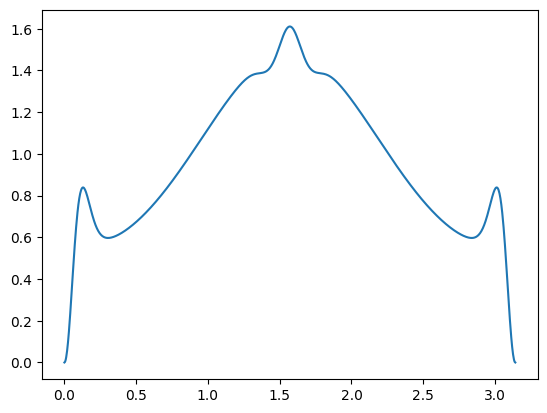

In [76]:
plt.plot(theta_range, np.multiply(2 * n, variances))
plt.show()

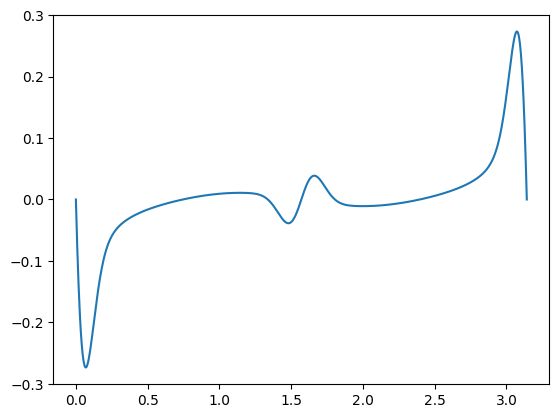

In [77]:
plt.plot(theta_range, np.multiply(means - theta_range, np.sqrt(n)))
plt.show()

Not sure if the bump around pi/2 is because of rounding errors or genuine variance

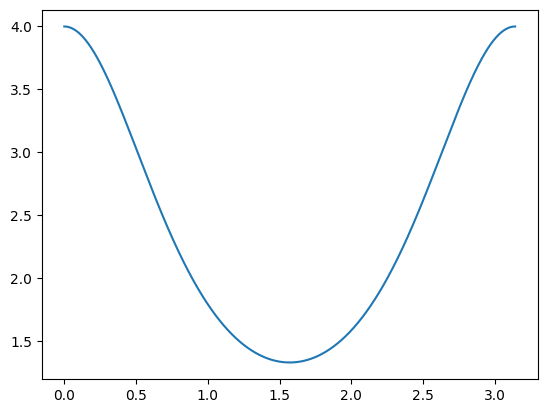

In [78]:
# plot the fisher information
fisher_information_numerator = 4 * (3 + np.cos(theta_range) ** 2)
fisher_information_denominator = (3 - np.cos(theta_range) ** 2) ** 2
fisher_information = fisher_information_numerator / fisher_information_denominator

plt.plot(theta_range, fisher_information)
plt.show()

In [79]:
# get the means and variances for each n
means = []
variances = []

theta_samples = 501
n_range = [40, 200]
theta_range = np.linspace(0, np.pi, theta_samples)

for n in n_range:
    _, m, v = calculate_multinom_ppnrd_stats(theta_samples, n)
    means.append(m)
    variances.append(v)

In [80]:
fisher_information_numerator = 4 * (3 + np.cos(theta_range) ** 2)
fisher_information_denominator = (3 - np.cos(theta_range) ** 2) ** 2
fisher_information = fisher_information_numerator / fisher_information_denominator

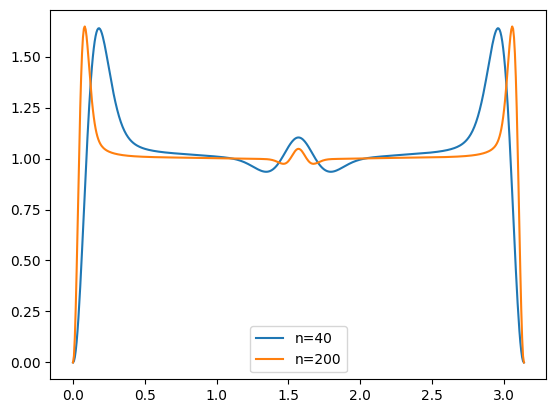

In [81]:
plt.figure()
for n in n_range:
    plt.plot(
        theta_range,
        np.multiply(fisher_information * n, variances[n_range.index(n)]),
        label=f"n={n}",
    )

plt.legend()
plt.show()

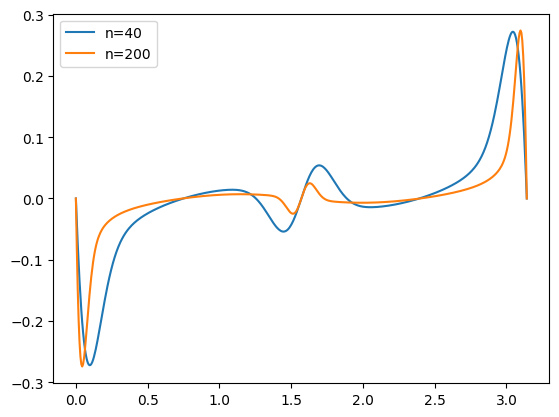

In [82]:
plt.figure()
for n in n_range:
    plt.plot(
        theta_range,
        np.multiply(means[n_range.index(n)] - theta_range, np.sqrt(n)),
        label=f"n={n}",
    )

plt.legend()
plt.show()

# Delta

## As per paper

In [4]:
# plot the multinomial distribution

n = 40

theta = 0.5 * np.pi
delta = 0.25 * np.pi

p_c = 1 / 2 * np.sin(theta) ** 2 * np.sin(delta) ** 2
p_sb = 1 / 2 * np.sin(theta) ** 2 * np.cos(delta) ** 2

p_neither = 1 - p_c - p_sb

p = [p_c, p_sb, p_neither]

multinom_db = multinomial(n, p)

multinom_db.pmf([10, 10, 20])

np.float64(0.02208994556602762)

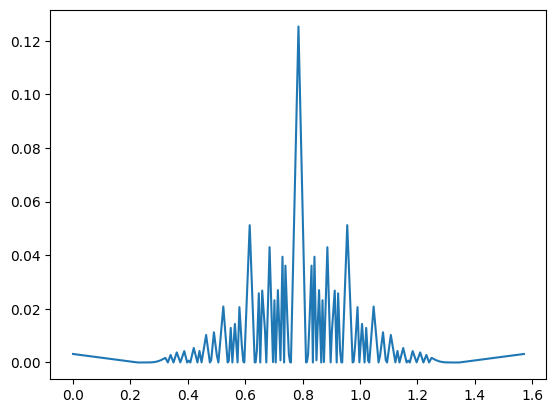

In [5]:
def get_multinom_arctan_pmf(n, theta, delta):
    p_c = 1 / 2 * np.sin(theta) ** 2 * np.sin(delta) ** 2
    p_sb = 1 / 2 * np.sin(theta) ** 2 * np.cos(delta) ** 2

    p_neither = 1 - p_c - p_sb

    p = [p_c, p_sb, p_neither]
    multinom_db = multinomial(n, p)

    n_counts = [[i, j, n - i - j] for i in range(n + 1) for j in range(n + 1 - i)]

    pmf_counts = multinom_db.pmf(n_counts)

    pmf = pd.DataFrame(n_counts)

    pmf["pmf"] = pmf_counts
    pmf["n_c"] = pmf[0].astype(int)
    pmf["n_sb"] = pmf[1].astype(int)
    pmf["n_neither"] = pmf[2].astype(int)

    pmf["under_the_root"] = pmf["n_c"] / pmf["n_sb"]
    pmf["arctan_argument"] = np.sqrt(pmf["under_the_root"])
    pmf["pmf_delta_tilde"] = np.arctan(pmf["arctan_argument"])

    # sum up contributions for the same theta_tilde
    pmf = pmf.groupby("pmf_delta_tilde").sum()["pmf"]
    pmf = pmf.reset_index()

    # renormalise to account for rounding errors
    pmf["pmf"] = pmf["pmf"] / np.sum(pmf["pmf"])

    return pmf


num_samples = 20
pmf_s = get_multinom_arctan_pmf(num_samples, 0.5 * np.pi, 0.25 * np.pi)
plt.plot(pmf_s["pmf_delta_tilde"], pmf_s["pmf"])
plt.show()

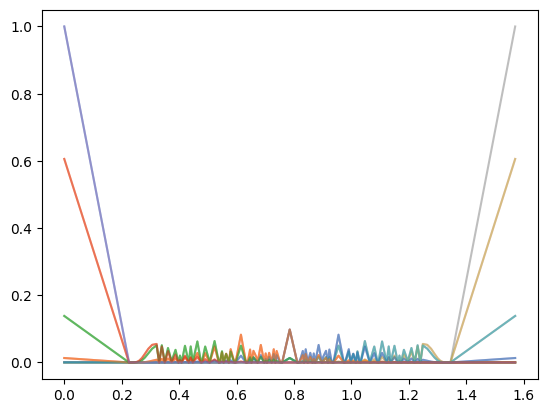

In [6]:
theta = 0.5 * np.pi

# show some of the pmfs for different deltas
delta_range = np.linspace(0, np.pi, 15)

# get the pmf for each theta
n = 20
pmf_z = [get_multinom_arctan_pmf(n, theta, delta) for delta in delta_range]

# plot the pmfs
plt.figure()
for pmf in pmf_z:
    plt.plot(pmf["pmf_delta_tilde"], pmf["pmf"], alpha=0.5)

plt.show()

In [7]:
def calculate_multinom_delta_stats(theta, delta_samples, n):
    delta_range = np.linspace(0, np.pi / 2, delta_samples)
    pmf_z = [get_multinom_arctan_pmf(n, theta, delta) for delta in delta_range]

    variances = []
    means = []

    for pmf in pmf_z:
        delta_tilde = pmf["pmf_delta_tilde"]
        pmf = pmf["pmf"]

        mean = np.sum(delta_tilde * pmf)
        var = np.sum((delta_tilde) ** 2 * pmf) - mean**2

        means.append(mean)
        variances.append(var)

    return theta, delta_range, means, variances

In [8]:
delta_samples = 501
n_range = [40, 80, 120, 160, 200]
thetas = np.array([0.25,0.255, 0.5]) * np.pi

delta_range = np.linspace(0, np.pi / 2, delta_samples)

In [9]:
# get the means and variances for each n
means = []
variances = []

for theta in thetas:
    for n in n_range:
        _, _, m, v = calculate_multinom_delta_stats(theta, delta_samples, n)
        means.append(m)
        variances.append(v)

In [10]:
# df = pd.DataFrame({
#     "delta_phi": np.tile(delta_range, len(n_range)),
#     "theta": np.repeat([theta] * len(delta_range), len(n_range)),
#     "n": np.repeat(n_range, len(delta_range)),
#     "delta_phi_estimator_mean": np.concatenate(means),
#     "delta_phi_estimator_variance": np.concatenate(variances)
# })

df = pd.DataFrame({
    "delta_phi": np.tile(delta_range, len(thetas) * len(n_range)),
    "theta": np.repeat(thetas, len(n_range) * len(delta_range)),
    "n": np.tile(np.repeat(n_range, len(delta_range)), len(thetas)),
    "delta_phi_estimator_mean": np.concatenate(means),
    "delta_phi_estimator_variance": np.concatenate(variances)
})



df.to_csv("delta_phi_estimator_stats.csv", index=False)
df

,delta_phi,theta,n,delta_phi_estimator_mean,delta_phi_estimator_variance
0,0.000000,0.785398,40,0.000000,0.000000
1,0.003142,0.785398,40,0.000031,0.000010
2,0.006283,0.785398,40,0.000126,0.000041
3,0.009425,0.785398,40,0.000283,0.000092
4,0.012566,0.785398,40,0.000503,0.000164
...,...,...,...,...,...
7510,1.558230,1.570796,200,1.569223,0.000156
7511,1.561372,1.570796,200,1.569909,0.000088
7512,1.564513,1.570796,200,1.570402,0.000039
7513,1.567655,1.570796,200,1.570698,0.000010


/tmp/ipykernel_704737/3981264155.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["n"] == n][df["theta"] == theta]["delta_phi"],
/tmp/ipykernel_704737/3981264155.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.multiply(2 * n, df[df["n"] == n][df["theta"] == theta]["delta_phi_estimator_variance"]),
/tmp/ipykernel_704737/3981264155.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["n"] == n][df["theta"] == theta]["delta_phi"],
/tmp/ipykernel_704737/3981264155.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  np.multiply(2 * n, df[df["n"] == n][df["theta"] == theta]["delta_phi_estimator_variance"]),
/tmp/ipykernel_704737/3981264155.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["n"] == n][df["theta"] == theta]["delta_phi"],
/tmp/ipykernel_704737/3981264155.py:6: UserWarning: Boolean Series key w

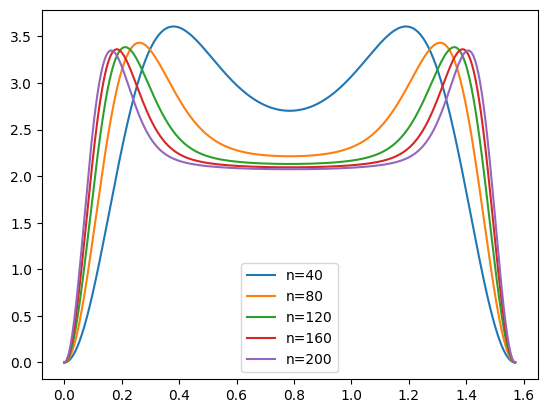

In [11]:
plt.figure()
theta = 0.25 * np.pi
for n in n_range:
    plt.plot(
        df[df["n"] == n][df["theta"] == theta]["delta_phi"],
        np.multiply(2 * n, df[df["n"] == n][df["theta"] == theta]["delta_phi_estimator_variance"]),
        label=f"n={n}",
    )

plt.legend()
plt.show()

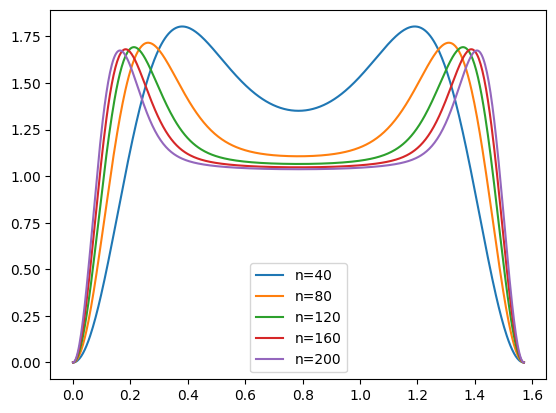

In [12]:
plt.figure()
theta = 0.25 * np.pi
for n in n_range:
    plt.plot(
        delta_range,
        np.multiply(2 * n * np.sin(theta) ** 2, variances[n_range.index(n)]),
        label=f"n={n}",
    )

plt.legend()
plt.show()

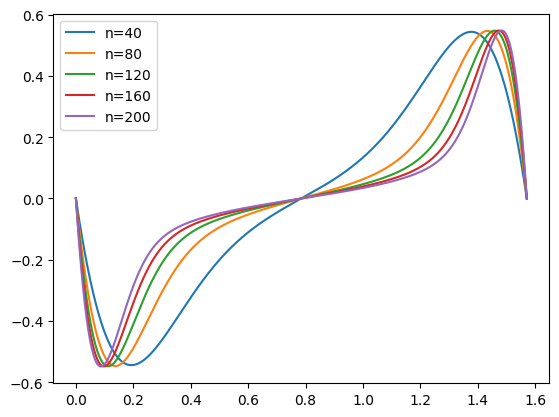

In [13]:
plt.figure()
for n in n_range:
    plt.plot(
        delta_range,
        np.multiply(np.sqrt(n), means[n_range.index(n)] - delta_range),
        label=f"n={n}",
    )

plt.legend()
plt.show()